# Simulate and analyze data with NEST and Elephant

[<img src="https://nest-simulator.org/TryItOnEBRAINS.png" width=300px>](https://lab.ebrains.eu/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgitlab.ebrains.eu%2Fnest%2Febrains-examples&urlpath=lab%2Ftree%2Febrains-examples%2Fsource%2Fnest-elephant-example%2FNEST-Elephant-Workflow.ipynb&branch=main)

## NEST and Elephant overview

[NEST](https://nest-simulator.org/documentation) is a simulation software that can output a variety of data. One aim of NEST is to create biologically realistic electrophysiological output in a computer simulation, rather than a real world experiment.  
[Elephant](https://elephant.readthedocs.io/) is an analysis toolkit for electrophysiological data. So it can take real world data or data generated by simulators like NEST.

The output generated by NEST can be imported into Elephant with a few lines of code.


Here we will show an overview of what lines you need to include in both NEST and Elephant so they work together, and additionally show an entire NEST and Elephant script to show a realistic analysis using Elephant of output from NEST.

* Both NEST and Elephant have examples you can learn from. Explore the documentation for NEST and Elephant to learn about all the possibilities.
    
    * Available notebooks for PyNEST examples can be accessed from online documentation (https://nest-simulator.readthedocs.io/en/stable/examples/index.html) 

    * Elephant provides notebooks to their tutorial series in the online documentation: https://elephant.readthedocs.io/en/latest/tutorials.html

----
## Quick summary of your NEST and Elephant scripts 

With a few lines of code in your NEST and Elephant scripts, you can output the correct data from NEST and import them into Elephant.
Here is the summary of the lines required in your scripts.

### Setup in NEST 

Generate output that can be read by Elephant.


In your NEST script, you need to

* create the type of recorder you want output from.
    
        espikes = nest.Create("spike_recorder")        
        ispikes = nest.Create("spike_recorder")
        
* Set the recorder to output to text file (ascii) in .dat or .gdf format. See documentation for more info: https://nest-simulator.readthedocs.io/en/latest/whats_new/v3.0/features/recording_simulations.html
    
        espikes.set(label="brunel-py-ex", record_to="ascii", file_extension="gdf")        
        ispikes.set(label="brunel-py-in", record_to="ascii", file_extension="gdf")
        
* Connect your recorder in your network and run the simulation. Your output will appear after simulation.
     
        nest.Connect(nodes_ex, espikes, syn_spec="excitatory")        
        nest.Connect(nodes_in, ispikes, syn_spec="excitatory")        
        nest.Simulate(1000.0)

### Setup in Elephant 

Import data from NEST.

In your Elephant script, you need to

* Remove the header lines from the output files.

        for file in gdf_files:
           !tail -n +4 {file}>{'no_header_'+file} # start at line 4 and save
           
* Import from neo, NESTIO

        from neo.io.nestio import NestIO
        
* Prepare the file(s) so it's usable by Elephant

        file = ('no_header_'+gdf_files[0])
        IO = NestIO(filenames=file)
        seg = IO.read_segment(
                     gid_list=[], # empty list to retrieve spiketrains from all neurons
                     t_start=0 * pq.ms,
                     t_stop=1000 * pq.ms,
                     id_column_gdf=0,  # column 0 contains the neuron ID
                     time_column_gdf=1, # column 1 contains the times in ms
                     )


----

# Full example NEST-Elephant workflow

Here you can see how the lines summarized above look in a real example.



In [33]:
%matplotlib inline

## Random balanced network (delta synapses)

This script simulates an excitatory and an inhibitory population on
the basis of the network used in [1]_

This example of a random balanced network has been adapted from https://nest-simulator.readthedocs.io/en/stable/auto_examples/brunel_delta_nest.html.

When connecting the network, customary synapse models are used, which
allow for querying the number of created synapses. Using spike
recorders, the average firing rates of the neurons in the populations
are established. The building as well as the simulation time of the
network are recorded.

### References

.. [1] Brunel N (2000). Dynamics of sparsely connected networks of excitatory and
       inhibitory spiking neurons. Journal of Computational Neuroscience 8,
       183-208.


Import all necessary modules 

In [34]:
import nest

nest.ResetKernel()

Assigning the simulation parameters to variables.



In [35]:
dt = 0.1  # the resolution in ms
simtime = 1000.0  # Simulation time in ms
delay = 1.5  # synaptic delay in ms

Definition of the parameters crucial for asynchronous irregular firing of
the neurons.



In [36]:
g = 5.0  # ratio inhibitory weight/excitatory weight
eta = 2.0  # external rate relative to threshold rate
epsilon = 0.1  # connection probability

Definition of the number of neurons in the network and the number of neurons
recorded from



In [37]:
order = 500 # originally 2500
NE = 4 * order  # number of excitatory neurons
NI = 1 * order  # number of inhibitory neurons
N_neurons = NE + NI  # number of neurons in total
N_rec = 50  # record from 50 neurons

Definition of connectivity parameters



In [38]:
CE = int(epsilon * NE)  # number of excitatory synapses per neuron
CI = int(epsilon * NI)  # number of inhibitory synapses per neuron
C_tot = int(CI + CE)  # total number of synapses per neuron

Initialization of the parameters of the integrate and fire neuron and the
synapses. The parameters of the neuron are stored in a dictionary.



In [39]:
tauMem = 20.0  # time constant of membrane potential in ms
theta = 20.0  # membrane threshold potential in mV
neuron_params = {"C_m": 1.0,
                 "tau_m": tauMem,
                 "t_ref": 2.0,
                 "E_L": 0.0,
                 "V_reset": 0.0,
                 "V_m": 0.0,
                 "V_th": theta}
J = 0.1  # postsynaptic amplitude in mV
J_ex = J  # amplitude of excitatory postsynaptic potential
J_in = -g * J_ex  # amplitude of inhibitory postsynaptic potential

Definition of threshold rate, which is the external rate needed to fix the
membrane potential around its threshold, the external firing rate and the
rate of the poisson generator which is multiplied by the in-degree CE and
converted to Hz by multiplication by 1000.



In [40]:
nu_th = theta / (J * CE * tauMem)
nu_ex = eta * nu_th
p_rate = 1000.0 * nu_ex * CE

Configuration of the simulation kernel by the previously defined time
resolution used in the simulation. 



In [41]:
nest.resolution = dt
nest.overwrite_files = True

print("Building network")

Building network

Aug 23 11:55:46 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


Creation of the nodes using ``Create``. We store the returned handles in
variables for later reference. Here the excitatory and inhibitory, as well
as the poisson generator and two spike recorders. The spike recorders will
later be used to record excitatory and inhibitory spikes. Properties of the
nodes are specified via ``params``, which expects a dictionary.



In [42]:
nodes_ex = nest.Create("iaf_psc_delta", NE, params=neuron_params)
nodes_in = nest.Create("iaf_psc_delta", NI, params=neuron_params)
noise = nest.Create("poisson_generator", params={"rate": p_rate})
espikes = nest.Create("spike_recorder")
ispikes = nest.Create("spike_recorder")

Configuration of the spike recorders recording excitatory and inhibitory
spikes by sending parameter dictionaries to ``set``. Setting the property
`record_to` to *"ascii"* ensures that the spikes will be recorded to a file,
whose name starts with the string assigned to the property `label`.



In [43]:
espikes.set(label="brunel-py-ex", record_to="ascii", file_extension="gdf")
ispikes.set(label="brunel-py-in", record_to="ascii", file_extension="gdf")

print("Connecting devices")

Connecting devices


Definition of a synapse using ``CopyModel``, which expects the model name of
a pre-defined synapse, the name of the customary synapse and an optional
parameter dictionary. The parameters defined in the dictionary will be the
default parameter for the customary synapse. Here we define one synapse for
the excitatory and one for the inhibitory connections giving the
previously defined weights and equal delays.



In [44]:
nest.CopyModel("static_synapse", "excitatory",
               {"weight": J_ex, "delay": delay})
nest.CopyModel("static_synapse", "inhibitory",
               {"weight": J_in, "delay": delay})

Connecting the previously defined poisson generator to the excitatory and
inhibitory neurons using the excitatory synapse. Since the poisson
generator is connected to all neurons in the population the default rule
(# ``all_to_all``) of ``Connect`` is used. The synaptic properties are inserted
via ``syn_spec`` which expects a dictionary when defining multiple variables
or a string when simply using a pre-defined synapse.



In [45]:
nest.Connect(noise, nodes_ex, syn_spec="excitatory")
nest.Connect(noise, nodes_in, syn_spec="excitatory")

Connecting the first ``N_rec`` nodes of the excitatory and inhibitory
population to the associated spike recorders using excitatory synapses.
Here the same shortcut for the specification of the synapse as defined
above is used.



In [46]:
nest.Connect(nodes_ex[:N_rec], espikes, syn_spec="excitatory")
nest.Connect(nodes_in[:N_rec], ispikes, syn_spec="excitatory")

print("Connecting network")

print("Excitatory connections")

Connecting network
Excitatory connections


Connecting the excitatory population to all neurons using the pre-defined
excitatory synapse. Beforehand, the connection parameter are defined in a
dictionary. Here we use the connection rule ``fixed_indegree``,
which requires the definition of the indegree. Since the synapse
specification is reduced to assigning the pre-defined excitatory synapse it
suffices to insert a string.



In [47]:
conn_params_ex = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, "excitatory")

print("Inhibitory connections")

Inhibitory connections


Connecting the inhibitory population to all neurons using the pre-defined
inhibitory synapse. The connection parameters as well as the synapse
parameters are defined analogously to the connection from the excitatory
population defined above.



In [48]:
conn_params_in = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, "inhibitory")

Simulation of the network.



In [49]:
print("Simulating")

nest.Simulate(simtime)

Simulating

Aug 23 11:55:47 NodeManager::prepare_nodes [Info]: 
    Preparing 2503 nodes for simulation.

Aug 23 11:55:47 SimulationManager::run [Warning]: 
    The requested simulation time is not an integer multiple of the minimal 
    delay in the network. This may result in inconsistent results under the 
    following conditions: (i) A network contains more than one source of 
    randomness, e.g., two different poisson_generators, and (ii) Simulate is 
    called repeatedly with simulation times that are not multiples of the 
    minimal delay.

Aug 23 11:55:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2503
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Aug 23 11:55:49 SimulationManager::run [Info]: 
    Simulation finished.


Storage of the time point after the simulation of the network in a variable.



## Process NEST data with Elephant
This script loads the simulation data generated with NEST in `brunel_alpha_nest.ipynb` and performs anaysis with Elephant (Electrophysiology Analysis Toolkit).

First, delete the descriptive meta-data header prior to data.

In order to use the `neo.io.nestio` the meta-data header for each column needs to be removed.


*In addition, most backends now write the name of the recorded variable for each column as a descriptive meta-data header prior to writing any data.\
see: (https://nest-simulator.readthedocs.io/en/stable/release_notes/v3.0/features/recording_simulations.html?highlight=meta-data)*

Until the IO for NEST in Neo is updated, the following hotfix is applied to the `.gdf`-files:\
(*once Neo is updated, simply remove* `'no_header_'`)

In [65]:
# Load the gdf files from the simulation:
gdf_files=['brunel-py-ex-2502-0.gdf','brunel-py-in-5203-0.gdf']
#gdf_folder=('brunel_alpha_nest_output'+'/')

for file in gdf_files:
    !tail -n +4 {file}>{'no_header_'+file} # start at line 4 and save

tail: cannot open 'brunel-py-in-5203-0.gdf' for reading: No such file or directory


---

### Load simulation data 

In this example the data from the `.gdf` files is loaded using the nestIO from Neo package.

See also: https://neo.readthedocs.io/

In [51]:
import quantities as pq
from neo.io.nestio import NestIO

file = ('no_header_'+gdf_files[0])
IO = NestIO(filenames=file)
seg = IO.read_segment(
                     gid_list=[], # empty list to retrieve spiketrains from all neurons
                     t_start=0 * pq.ms,
                     t_stop=1000 * pq.ms,
                     id_column_gdf=0,  # column 0 contains the neuron ID
                     time_column_gdf=1, # column 1 contains the times in ms
                     )

### 1. Elephant: Calculate instantaneous firing rates

The mean firing rate is just the temporal average of the number of spikes per time in the spiking activity of the neuron for the
whole trial. We can have a time-varying estimate of the firing rate along the duration of the trial by computing the instantaneous rate.

For this estimation, Elephant's `statistics` module provides the `instantaneous_rate` function. The function performs kernel
convolution: each spike that ocurred during the trial is blurred with a kernel function. The bandwidth of the kernel function is
controlled by the parameter `sigma`. Different types of kernel and bandwidths can be selected for more or less smooth estimates.

Let's plot the instantaneous rate for one neuron that we are analyzing. Let's use a Gaussian kernel with two different `sigma`
parameters: `20 ms` or `100 ms`. Use `.1 ms` as `sampling_period`.

In [52]:
from elephant import statistics
from elephant import kernels

spiketrain_id=0
# Define kernel 1
kernel_1 = kernels.GaussianKernel(sigma=20 * pq.ms)
# calculate instantaneous firing rate 1
inst_rate_1 = statistics.instantaneous_rate(
                                    seg.spiketrains[spiketrain_id],
                                    sampling_period=.1 * pq.ms,
                                    kernel=kernel_1
                                    )

# Define kernel 2
kernel_2 = kernels.GaussianKernel(sigma=100 * pq.ms)
# calculate instantaneous firing rate 2
inst_rate_2 = statistics.instantaneous_rate(
                                    seg.spiketrains[spiketrain_id],
                                    sampling_period=.1 * pq.ms,
                                    kernel=kernel_2
                                    )

### Plot analysis results

Execute the code below to plot the spike train together with the rate profile that we calculated.
The spike times will be added to the bottom of each plot. Note that the parameters of the rate computations
are retained in the resulting rate variables, which in turn are Neo `AnalogSignal` objects.

In [53]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, sharey=True, figsize=(12,6))
for plot, rates in enumerate([inst_rate_1, inst_rate_2]):
    axes[plot].plot(rates.times.rescale(pq.ms), rates, linewidth=2)
    axes[plot].eventplot(seg.spiketrains[spiketrain_id].magnitude, color='black', linelengths=5)
    axes[plot].set_ylabel("Firing rate (Hz)")
    axes[plot].set_title(f"$\sigma$ = {rates.annotations['kernel']['sigma']}")
axes[-1].set_xlabel("Time (ms)");

We can see that the smoothness of the rate curve is affected by the sigma parameter. Elephant can try to estimate the best kernel bandwidth for a Gaussian kernel by using 'auto' as the value of the kernel parameter. Let's try this option.

In [54]:
rates_auto = statistics.instantaneous_rate(
                                            seg.spiketrains[spiketrain_id],
                                            kernel='auto', 
                                            sampling_period=.1 * pq.ms,
                                            )

Execute the code below to plot the instantaneous firing rate obtained from the automatic kernel bandwidth.

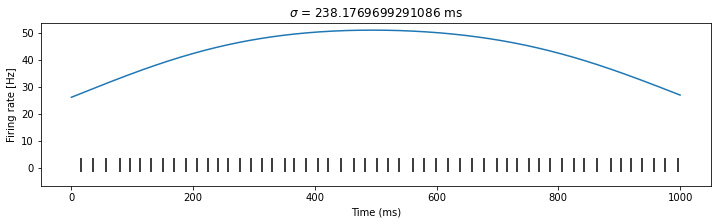

In [55]:
fig, axes = plt.subplots(figsize=(12,3))
axes.plot(rates_auto.times.rescale(pq.ms), rates_auto)
axes.eventplot(seg.spiketrains[spiketrain_id].magnitude, color='black', linelengths=5)
axes.set_ylabel("Firing rate [Hz]")
axes.set_xlabel("Time (ms)")
axes.set_title(f"$\sigma$ = {rates_auto.annotations['kernel']['sigma']}");

Finally, let's compute and plot the instantaneous firing rates for all spiketrains.

You can pass the list with all spike trains for the instantaneous_rate function, to generate a 2D-matrix. Use `kernel_1` as the kernel parameter and .1 ms as sampling_period.

In [56]:
all_rates = statistics.instantaneous_rate(
                                            seg.spiketrains, 
                                            kernel=kernel_1, 
                                            sampling_period=.1 * pq.ms,
                                            )

### Viziphant

Viziphant provides a high-level API to easily generate plots and interactive visualizations of neuroscientific data and analysis results. See also https://viziphant.readthedocs.io/

You can now use the Viziphant function `plot_instantaneous_rates_colormesh` to plot the rates of all spiketrains.



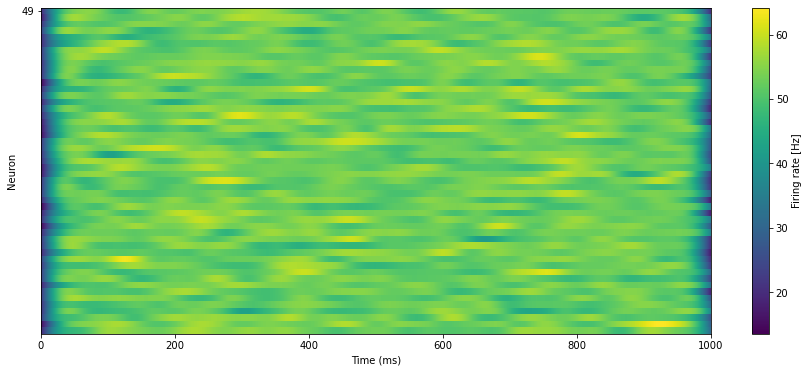

In [57]:
import viziphant
# Create the axes, setting the figure size
fig, axes = plt.subplots(figsize=(15,6))
# Plot the rates using the axes
viziphant.statistics.plot_instantaneous_rates_colormesh(all_rates, axes=axes);

### 2. Elephant: Investigate the spike train correlations

From the rasterplot that we generated above, it is difficult to assess if there are correlations between the spike trains.

To investigate that, Elephant provides functions to calculate and plot the cross-correlation matrix. This matrix quantifies the similarity for each pair of spike trains in the trial. We start by binning the spike trains. With this, we are obtaining the number of spikes that occurred during small intervals. Let's use a bin size of 3 ms.

In [58]:
from elephant import conversion
binned_spiketrains = conversion.BinnedSpikeTrain(
                                                seg.spiketrains, 
                                                binsize=3*pq.ms
                                                )

The binning above showed several warnings that happened due to the machine error precision of floating point computation. Since now we're aware of it, let's filter them out throughout the rest of the notebook.

In [59]:
import warnings
warnings.filterwarnings("ignore")

If we inspect the spike times of one neuron, we can see that if the neuron fired in a particular bin,
the `BinnedSpikeTrain` object will store the value 1.

In [60]:
print("Timepoints in ms where spike occured")
print(seg.spiketrains[spiketrain_id])

Timepoints in ms where spike occured
[ 16.2  35.8  57.4  79.4  95.8 112.9 131.2 149.7 168.  188.2 206.4 223.8
 240.2 258.  276.8 295.6 313.1 329.6 350.8 366.4 384.7 404.6 422.3 443.5
 464.6 481.9 502.1 519.5 538.7 560.8 579.3 598.5 619.3 638.6 657.6 677.9
 699.1 715.9 732.4 751.6 768.6 786.  806.1 824.9 841.5 863.2 886.4 903.2
 919.1 937.5 957.  975.6 996.2] ms


In [61]:
print ("Index of the 3 ms bin that the spike occurred")
print(seg.spiketrains[spiketrain_id].times / (3 * pq.ms))

Index of the 3 ms bin that the spike occurred
[  5.4         11.93333333  19.13333333  26.46666667  31.93333333
  37.63333333  43.73333333  49.9         56.          62.73333333
  68.8         74.6         80.06666667  86.          92.26666667
  98.53333333 104.36666667 109.86666667 116.93333333 122.13333333
 128.23333333 134.86666667 140.76666667 147.83333333 154.86666667
 160.63333333 167.36666667 173.16666667 179.56666667 186.93333333
 193.1        199.5        206.43333333 212.86666667 219.2
 225.96666667 233.03333333 238.63333333 244.13333333 250.53333333
 256.2        262.         268.7        274.96666667 280.5
 287.73333333 295.46666667 301.06666667 306.36666667 312.5
 319.         325.2        332.06666667] dimensionless


In [62]:
print("Total number of bins: "+str(binned_spiketrains.n_bins))
print(binned_spiketrains.to_array()[0,:])

Total number of bins: 333
[0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1]


Then we calculate the cross-correlation matrix of the binned spikes using the `correlation_coefficient`
function from the `spike_train_correlation` module.

In [63]:
from elephant import spike_train_correlation
cross_corr_matrix = spike_train_correlation.correlation_coefficient(
    binned_spiketrains)

### Viziphant
We visualize the matrix using the plot_corrcoef function of Viziphant. To better visualize the coefficients, we will set correlation_range to 'auto', to use the color bar only in the range of the obtained coefficients. We will also not plot the values along the main diagonal, as those are equal to 1, by setting remove_diagonal to True.

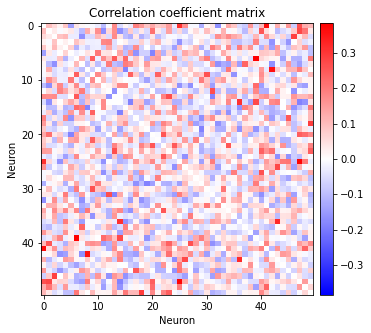

In [64]:
# Create the axes, setting the figure size
fig, axes = plt.subplots(figsize=(10,5))
# Plot the correlation matrix
viziphant.spike_train_correlation.plot_corrcoef(
    cross_corr_matrix, axes=axes,correlation_range='auto',remove_diagonal=True)
# Set labels and title
axes.set_xlabel('Neuron')
axes.set_ylabel('Neuron')
axes.set_title("Correlation coefficient matrix");